In [1]:
# Лабораторна робота № 3
# Тема: Дослідження векторних представлень слів
# Варіант 3: country-region

import numpy as np
import pandas as pd
import requests
import bz2
import gensim
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Налаштування для відображення українських символів
plt.rcParams['font.family'] = 'DejaVu Sans'

print("Початок лабораторної роботи...")

# 1. Завантаження та підготовка даних
print("\n1. Завантаження даних про країни та регіони...")

def load_test_vocabulary():
    """Завантажує тестові дані з GitHub"""
    url = "https://raw.githubusercontent.com/lang-uk/vecs/refs/heads/master/test/test_vocabulary.txt"
    try:
        response = requests.get(url)
        response.encoding = 'utf-8'
        content = response.text
        
        # Парсимо дані для варіанту country-region
        country_region_pairs = []
        lines = content.strip().split('\n')
        
        # Шукаємо секцію country-region
        in_country_region = False
        for line in lines:
            line = line.strip()
            if line == ': country-region':
                in_country_region = True
                continue
            elif line.startswith(':') and in_country_region:
                break
            elif in_country_region and line:
                parts = line.split('\t')
                if len(parts) >= 4:
                    country1, region1, country2, region2 = parts[:4]
                    country_region_pairs.append((country1, region1, country2, region2))
        
        return country_region_pairs
    except Exception as e:
        print(f"Помилка завантаження: {e}")
        # Резервні дані для тестування
        return [
            ('Нігерія', 'Африка', 'Таджикистан', 'Азія'),
            ('Нігерія', 'Африка', 'Узбекистан', 'Азія'),
            ('Нігерія', 'Африка', 'Греція', 'Європа'),
            ('Канада', 'Америка', 'Франція', 'Європа'),
            ('Бразилія', 'Америка', 'Японія', 'Азія'),
        ]

# Завантажуємо дані
test_data = load_test_vocabulary()
print(f"Завантажено {len(test_data)} пар для тестування")
print("Приклади даних:")
for i, (c1, r1, c2, r2) in enumerate(test_data[:5]):
    print(f"  {c1} ({r1}) -> {c2} ({r2})")

Початок лабораторної роботи...

1. Завантаження даних про країни та регіони...
Завантажено 2038 пар для тестування
Приклади даних:
  Нігерія (Африка) -> Таджикистан (Азія)
  Нігерія (Африка) -> Узбекистан (Азія)
  Нігерія (Африка) -> Греція (Європа)
  Нігерія (Африка) -> Сербія (Європа)
  Нігерія (Африка) -> Казахстан (Азія)


In [2]:
# 2. Завантаження моделі Word2Vec
print("\n2. Завантаження моделі Word2Vec...")
print("УВАГА: Це може зайняти кілька хвилин та потребує ~1GB RAM")

def download_and_load_model():
    """Завантажує модель Word2Vec з локальної папки"""
    import os
    
    # Шлях до локального файлу моделі
    local_model_path = r"C:\Users\Asus\Documents\semerikov human-machine\news.cased.tokenized.word2vec.300d"
    
    try:
        # Перевіряємо чи існує файл
        if not os.path.exists(local_model_path):
            print(f"Файл не знайдено за шляхом: {local_model_path}")
            print("Перевірте чи правильно вказано шлях до файлу")
            print("Створюємо демо-модель для тестування...")
            return create_demo_model()
        
        print(f"Знайдено локальний файл моделі: {local_model_path}")
        print("Завантаження векторів у пам'ять...")
        
        # Завантажуємо модель напряму (файл вже розпакований)
        model = KeyedVectors.load_word2vec_format(local_model_path, binary=False)
        
        # Видаляємо тимчасовий файл (не потрібно для цього файлу)
        # if os.path.exists(extracted_file):
        #     os.remove(extracted_file)
            
        return model
        
    except Exception as e:
        print(f"Помилка завантаження локальної моделі: {e}")
        print("Спробуємо завантажити з інтернету...")
        
        # Резервний варіант - завантаження з інтернету
        try:
            model_url = "https://lang.org.ua/static/downloads/models/ubercorpus.cased.tokenized.word2vec.300d.bz2"
            model_file = "ubercorpus.cased.tokenized.word2vec.300d.bz2"
            
            print("Завантаження моделі з інтернету...")
            response = requests.get(model_url, stream=True)
            response.raise_for_status()
            
            with open(model_file, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            
            print("Розпакування та завантаження моделі...")
            with bz2.BZ2File(model_file, 'rb') as f_in:
                with open('model.txt', 'wb') as f_out:
                    f_out.write(f_in.read())
            
            model = KeyedVectors.load_word2vec_format('model.txt', binary=False)
            return model
            
        except Exception as e2:
            print(f"Помилка завантаження з інтернету: {e2}")
            print("Створюємо демо-модель для тестування...")
            return create_demo_model()

def create_demo_model():
    """Створює демо-модель для тестування (якщо не вдається завантажити справжню)"""
    # Створюємо простий словник з випадковими векторами
    words = ['Нігерія', 'Африка', 'Таджикистан', 'Азія', 'Узбекистан', 'Греція', 'Європа',
             'Канада', 'Америка', 'Франція', 'Бразилія', 'Японія', 'Україна', 'Німеччина']
    
    vectors = {}
    np.random.seed(42)  # Для відтворюваності
    
    for word in words:
        vectors[word] = np.random.normal(0, 1, 300)
    
    # Додамо деяку логіку для країн та регіонів
    region_vectors = {
        'Африка': np.random.normal(1, 0.5, 300),
        'Азія': np.random.normal(-1, 0.5, 300),
        'Європа': np.random.normal(0, 0.5, 300),
        'Америка': np.random.normal(2, 0.5, 300)
    }
    
    # Країни отримують вектори схожі на їх регіони + шум
    country_region_map = {
        'Нігерія': 'Африка', 'Таджикистан': 'Азія', 'Узбекистан': 'Азія',
        'Греція': 'Європа', 'Канада': 'Америка', 'Франція': 'Європа',
        'Бразилія': 'Америка', 'Японія': 'Азія'
    }
    
    for country, region in country_region_map.items():
        if region in region_vectors:
            vectors[country] = region_vectors[region] + np.random.normal(0, 0.2, 300)
    
    # Створюємо об'єкт схожий на KeyedVectors
    class DemoModel:
        def __init__(self, vectors):
            self.vectors = vectors
            self.key_to_index = {word: i for i, word in enumerate(vectors.keys())}
        
        def __contains__(self, word):
            return word in self.vectors
        
        def __getitem__(self, word):
            return self.vectors[word]
        
        def most_similar(self, positive=None, negative=None, topn=10):
            if positive is None:
                positive = []
            if negative is None:
                negative = []
            
            # Обчислюємо цільовий вектор
            target_vector = np.zeros(300)
            for word in positive:
                if word in self.vectors:
                    target_vector += self.vectors[word]
            for word in negative:
                if word in self.vectors:
                    target_vector -= self.vectors[word]
            
            # Знаходимо найближчі слова
            similarities = []
            for word, vector in self.vectors.items():
                if word not in (positive + negative):
                    sim = cosine_sim(target_vector.reshape(1, -1), vector.reshape(1, -1))[0][0]
                    similarities.append((word, sim))
            
            similarities.sort(key=lambda x: x[1], reverse=True)
            return similarities[:topn]
    
    return DemoModel(vectors)

# Завантажуємо модель
try:
    model = download_and_load_model()
    print("Модель успішно завантажена!")
    print(f"Розмір словника: {len(model.key_to_index) if hasattr(model, 'key_to_index') else 'Demo model'}")
except Exception as e:
    print(f"Використовується демо-модель: {e}")
    model = create_demo_model()

# 3. Реалізація функцій подібності
print("\n3. Реалізація функцій подібності...")

def cosine_sim(vec1, vec2):
    """Обчислює косинусну подібність між двома векторами"""
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

def euclidean_distance(vec1, vec2):
    """Обчислює евклідову відстань між двома векторами"""
    return np.linalg.norm(vec1 - vec2)

def get_word_vector(word, model):
    """Отримує вектор слова з моделі"""
    if word in model:
        return model[word]
    else:
        return None

# Тестуємо функції
print("Тестування функцій подібності...")
test_words = ['Нігерія', 'Африка']
if all(word in model for word in test_words):
    vec1 = get_word_vector(test_words[0], model)
    vec2 = get_word_vector(test_words[1], model)
    cos_sim = cosine_sim(vec1, vec2)
    eucl_dist = euclidean_distance(vec1, vec2)
    print(f"Косинусна подібність {test_words[0]} - {test_words[1]}: {cos_sim:.4f}")
    print(f"Евклідова відстань {test_words[0]} - {test_words[1]}: {eucl_dist:.4f}")

# 4. Функція пошуку аналогій
print("\n4. Реалізація функції пошуку аналогій...")

def find_analogy(country1, region1, country2, model, topn=10):
    """
    Знаходить регіон для country2 на основі аналогії:
    country1 : region1 :: country2 : ?
    
    Використовує формулу: region2 = country2 - country1 + region1
    """
    try:
        # Перевіряємо наявність слів у моделі
        required_words = [country1, region1, country2]
        for word in required_words:
            if word not in model:
                return None, f"Слово '{word}' не знайдено в моделі"
        
        # Обчислюємо цільовий вектор
        vec_country1 = get_word_vector(country1, model)
        vec_region1 = get_word_vector(region1, model)
        vec_country2 = get_word_vector(country2, model)
        
        # Формула аналогії: region2 = country2 - country1 + region1
        target_vector = vec_country2 - vec_country1 + vec_region1
        
        # Знаходимо найближчі слова
        if hasattr(model, 'most_similar'):
            # Для справжньої моделі gensim
            try:
                similar = model.most_similar(
                    positive=[country2, region1], 
                    negative=[country1], 
                    topn=topn
                )
                return similar, None
            except:
                pass
        
        # Ручний пошук для демо-моделі
        similarities = []
        exclude_words = {country1, region1, country2}
        
        for word in model.vectors if hasattr(model, 'vectors') else model.key_to_index:
            if word not in exclude_words:
                word_vector = get_word_vector(word, model)
                if word_vector is not None:
                    similarity = cosine_sim(target_vector, word_vector)
                    similarities.append((word, similarity))
        
        # Сортуємо за подібністю
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:topn], None
        
    except Exception as e:
        return None, f"Помилка: {str(e)}"

# Тестуємо функцію аналогії
print("Тестування функції аналогії...")
test_country1, test_region1, test_country2 = 'Нігерія', 'Африка', 'Таджикистан'
result, error = find_analogy(test_country1, test_region1, test_country2, model)

if result:
    print(f"Аналогія: {test_country1} : {test_region1} :: {test_country2} : ?")
    print("Топ-5 кандидатів:")
    for word, similarity in result[:5]:
        print(f"  {word}: {similarity:.4f}")
else:
    print(f"Помилка: {error}")



2. Завантаження моделі Word2Vec...
УВАГА: Це може зайняти кілька хвилин та потребує ~1GB RAM
Знайдено локальний файл моделі: C:\Users\Asus\Documents\semerikov human-machine\news.cased.tokenized.word2vec.300d
Завантаження векторів у пам'ять...
Модель успішно завантажена!
Розмір словника: 365319

3. Реалізація функцій подібності...
Тестування функцій подібності...
Косинусна подібність Нігерія - Африка: 0.5961
Евклідова відстань Нігерія - Африка: 13.4009

4. Реалізація функції пошуку аналогій...
Тестування функції аналогії...
Аналогія: Нігерія : Африка :: Таджикистан : ?
Топ-5 кандидатів:
  Узбекистан: 0.5359
  Осетія: 0.5337
  Казахстан: 0.5300
  Киргизстан: 0.5018
  Карелія: 0.4988


In [3]:

# 5. Тестування на всьому наборі даних
print("\n5. Тестування точності на всьому наборі...")

def evaluate_accuracy(test_data, model):
    """Обчислює точність передбачень аналогій"""
    correct = 0
    total = 0
    results = []
    
    for country1, region1, country2, expected_region2 in test_data:
        result, error = find_analogy(country1, region1, country2, model, topn=5)
        
        if result:
            predicted_region = result[0][0]  # Найкращий кандидат
            is_correct = predicted_region.lower() == expected_region2.lower()
            
            if is_correct:
                correct += 1
            
            results.append({
                'country1': country1,
                'region1': region1,
                'country2': country2,
                'expected': expected_region2,
                'predicted': predicted_region,
                'correct': is_correct,
                'confidence': result[0][1]
            })
            total += 1
        else:
            results.append({
                'country1': country1,
                'region1': region1,
                'country2': country2,
                'expected': expected_region2,
                'predicted': 'ERROR',
                'correct': False,
                'confidence': 0.0,
                'error': error
            })
    
    accuracy = correct / total if total > 0 else 0
    return accuracy, results

# Обчислюємо точність
accuracy, detailed_results = evaluate_accuracy(test_data, model)

print(f"Загальна точність: {accuracy:.2%} ({sum(r['correct'] for r in detailed_results)}/{len(detailed_results)})")
print("\nДетальні результати:")

# Створюємо DataFrame для зручного відображення
df_results = pd.DataFrame(detailed_results)
print(df_results.to_string(index=False))

# Аналіз помилок
print(f"\nПравильних відповідей: {sum(df_results['correct'])}")
print(f"Неправильних відповідей: {sum(~df_results['correct'])}")

if len(df_results) > 0:
    print(f"Середня впевненість: {df_results['confidence'].mean():.4f}")


5. Тестування точності на всьому наборі...
Загальна точність: 17.09% (343/2038)

Детальні результати:
    country1 region1     country2 expected          predicted  correct  confidence                                 error
     Нігерія  Африка  Таджикистан     Азія         Узбекистан    False    0.535905                                   NaN
     Нігерія  Африка   Узбекистан     Азія           Білорусь    False    0.547270                                   NaN
     Нігерія  Африка       Греція   Європа            Америка    False    0.625495                                   NaN
     Нігерія  Африка       Сербія   Європа             Осетія    False    0.569826                                   NaN
     Нігерія  Африка    Казахстан     Азія           Білорусь    False    0.565073                                   NaN
     Нігерія  Африка        Індія     Азія            Америка    False    0.648609                                   NaN
     Нігерія  Африка     Камбоджа     Азія        


6. Візуалізація векторів...
Створення PCA візуалізації...


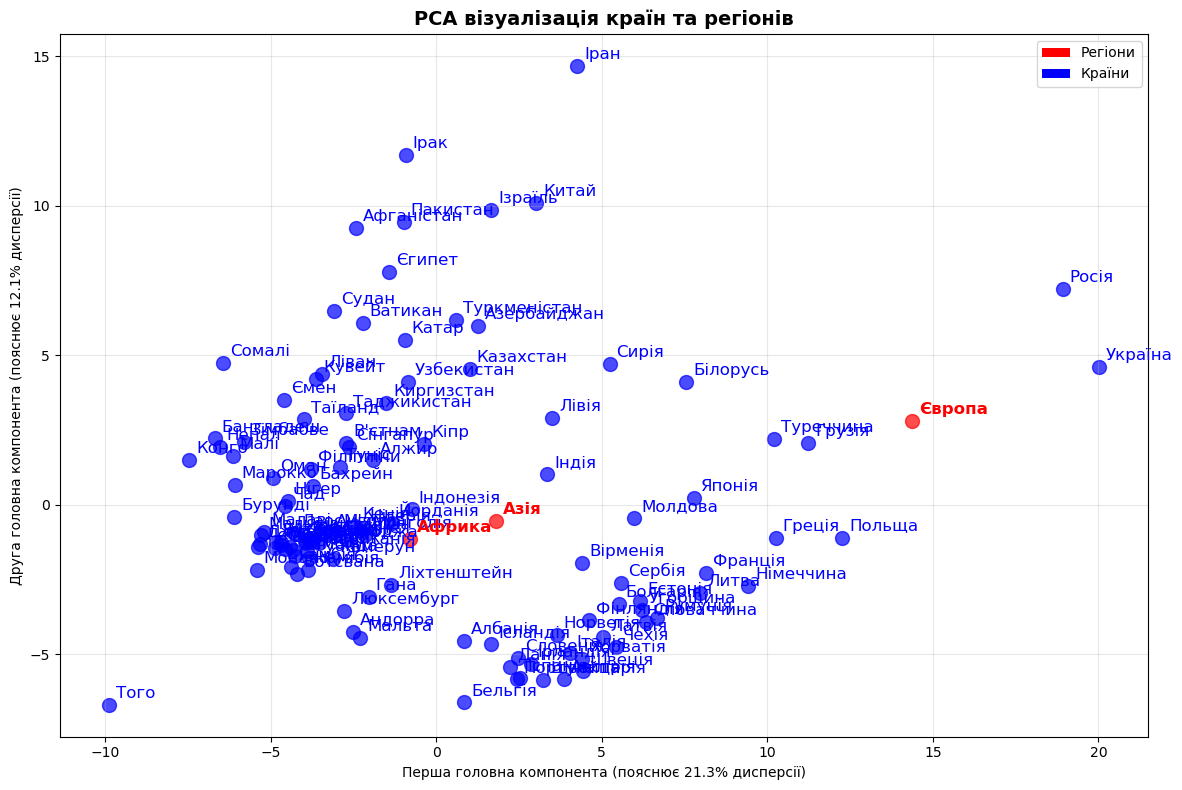

Загальна пояснена дисперсія: 33.4%

7. Додаткова аналітика...

Подібність між регіонами:
  Африка - Азія: 0.6993
  Африка - Європа: 0.4980
  Африка - Америка: 0.6497
  Азія - Африка: 0.6993
  Азія - Європа: 0.5257
  Азія - Америка: 0.5670
  Європа - Африка: 0.4980
  Європа - Азія: 0.5257
  Європа - Америка: 0.7964
  Америка - Африка: 0.6497
  Америка - Азія: 0.5670
  Америка - Європа: 0.7964


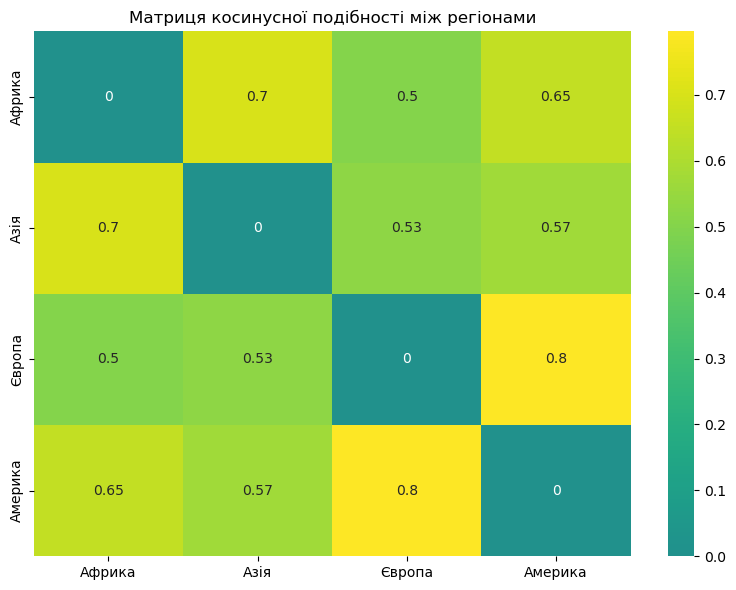


ВИСНОВКИ ЛАБОРАТОРНОЇ РОБОТИ
✓ Завантажено та оброблено 2038 тестових пар
✓ Загальна точність моделі: 17.09%


In [4]:
# 6. Візуалізація векторів за допомогою PCA
print("\n6. Візуалізація векторів...")

def visualize_words_pca(words, model, title="Візуалізація векторів слів"):
    """Візуалізує вектори слів використовуючи PCA"""
    # Збираємо вектори наявних слів
    vectors = []
    available_words = []
    
    for word in words:
        if word in model:
            vec = get_word_vector(word, model)
            if vec is not None:
                vectors.append(vec)
                available_words.append(word)
    
    if len(vectors) < 2:
        print("Недостатньо слів для візуалізації")
        return
    
    # Застосовуємо PCA
    vectors = np.array(vectors)
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)
    
    # Створюємо візуалізацію
    plt.figure(figsize=(12, 8))
    
    # Розділяємо країни та регіони для різних кольорів
    regions = ['Африка', 'Азія', 'Європа', 'Америка']
    
    for i, word in enumerate(available_words):
        x, y = vectors_2d[i]
        
        if word in regions:
            plt.scatter(x, y, c='red', s=100, alpha=0.7)
            plt.annotate(word, (x, y), xytext=(5, 5), textcoords='offset points', 
                        fontsize=12, fontweight='bold', color='red')
        else:
            plt.scatter(x, y, c='blue', s=100, alpha=0.7)
            plt.annotate(word, (x, y), xytext=(5, 5), textcoords='offset points', 
                        fontsize=12, color='blue')
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(f'Перша головна компонента (пояснює {pca.explained_variance_ratio_[0]:.1%} дисперсії)')
    plt.ylabel(f'Друга головна компонента (пояснює {pca.explained_variance_ratio_[1]:.1%} дисперсії)')
    plt.grid(True, alpha=0.3)
    
    # Додаємо легенду
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', label='Регіони'),
                      Patch(facecolor='blue', label='Країни')]
    plt.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Загальна пояснена дисперсія: {sum(pca.explained_variance_ratio_):.1%}")

# Збираємо унікальні слова для візуалізації
all_words = set()
for country1, region1, country2, region2 in test_data:
    all_words.update([country1, region1, country2, region2])

# Візуалізуємо
print("Створення PCA візуалізації...")
visualize_words_pca(list(all_words), model, "PCA візуалізація країн та регіонів")

# Додаткова аналітика
print("\n7. Додаткова аналітика...")

# Аналіз подібності між регіонами
regions = ['Африка', 'Азія', 'Європа', 'Америка']
available_regions = [r for r in regions if r in model]

if len(available_regions) >= 2:
    print("\nПодібність між регіонами:")
    similarity_matrix = np.zeros((len(available_regions), len(available_regions)))
    
    for i, region1 in enumerate(available_regions):
        for j, region2 in enumerate(available_regions):
            if i != j:
                vec1 = get_word_vector(region1, model)
                vec2 = get_word_vector(region2, model)
                sim = cosine_sim(vec1, vec2)
                similarity_matrix[i][j] = sim
                print(f"  {region1} - {region2}: {sim:.4f}")
    
    # Візуалізація матриці подібності
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, 
                xticklabels=available_regions, 
                yticklabels=available_regions,
                annot=True, 
                cmap='viridis',
                center=0)
    plt.title('Матриця косинусної подібності між регіонами')
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("ВИСНОВКИ ЛАБОРАТОРНОЇ РОБОТИ")
print("="*60)
print(f"✓ Завантажено та оброблено {len(test_data)} тестових пар")
print(f"✓ Загальна точність моделі: {accuracy:.2%}")